<a href="https://colab.research.google.com/github/s1c5000/kaggle/blob/main/Titanic/2_2_EDA_To_Prediction(titanic).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

캐글 필사: titanic 2     
* 원본 : https://www.kaggle.com/ash316/eda-to-prediction-dietanic

In [ ]:
# kaggle json
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning 이 일어나지 않도록 
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle competitions download -c titanic

  0% 0.00/28.0k [00:00<?, ?B/s]
100% 28.0k/28.0k [00:00<00:00, 10.5MB/s]
  0% 0.00/3.18k [00:00<?, ?B/s]
100% 3.18k/3.18k [00:00<00:00, 3.69MB/s]
  0% 0.00/59.8k [00:00<?, ?B/s]
100% 59.8k/59.8k [00:00<00:00, 51.9MB/s]


# 노트북의 내용
* 1. EDA
** 1-1. 특징분석
** 1-2. 다양한 관계를 고려하여 트렌드나 관계를 찾기

* 2. Feature engineering and data cleaning
** 2-1. 몇가지 feature추가
** 2-2. 중복기능 제거
** 2-3. feature들을 모델링에 적합한 형태로 만들기

* 3. Predictive modeling
** 3-1. 기본알고리즘
** 3-2. 교차검증(cross validation)
** 3-3. Ensembling
** 3-4. 중요feature 추출

# 1. EDA(Exploratory Data Analysis)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

plt.style.use('seaborn')
sns.set(font_scale=2)

import missingno as msno

In [ ]:
data = pd.read_csv('/content/train.csv')

In [ ]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Age와 Cabin, Embarked 가 null이 있다.

얼마나 살아남았나

Text(0.5, 1.0, 'Survived')

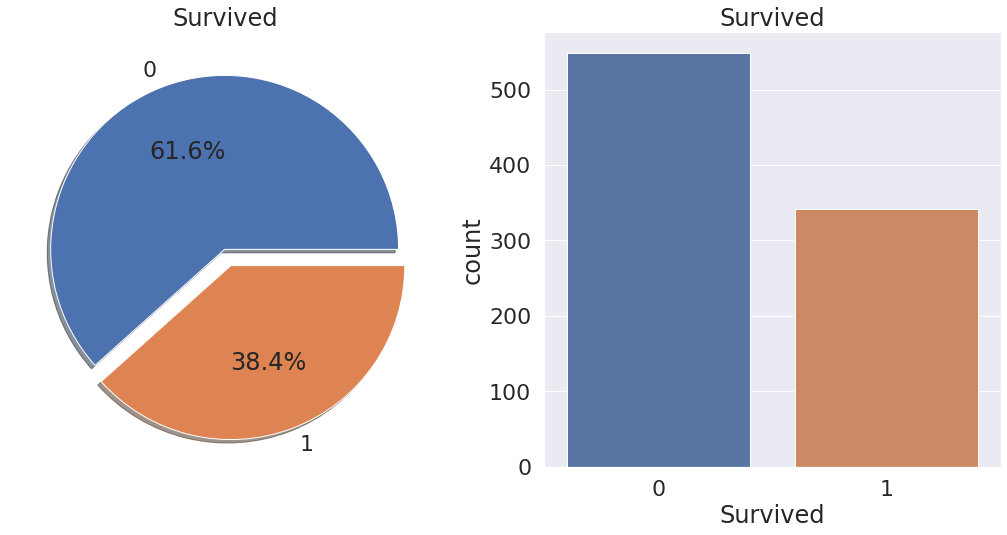

In [ ]:
f, ax = plt.subplots(1,2, figsize=(18,8))
data['Survived'].value_counts().plot.pie(explode=[0,0.1], autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('Survived')
ax[0].set_ylabel('')
sns.countplot('Survived', data=data, ax=ax[1])
ax[1].set_title('Survived')


* 살아남은 승객이 많지않다
* 전체중 38.4%만 살아남았다
* 데이터세트의 다양한 기능을 사용하여 생존율을 확인하려고 한다. 일부 기능은 Sex, Embarked, Age이다
* 먼저 다양한 유형의 기능을 이해하겠다

## Feature 들의 타입

#### Categorical Feature
* 범주형 변수는 범주가 두개 이상이고, 해당 feature의 각 값을 범주별로 분류 할 수 있는 변수이다. 에를 들어 Sex는 두 범주, 이러한 변수는 정렬하거나 순서를 지정할 수었다
* Sex, Embarked

#### ordinal Feature
* 순서형 변수는 범주형 변수와 유사하지만둘 사이의 차이점은 값간에 상대적인 순서나 정렬을 가질 수 있다는 것이다. 예를들어 Tall, Mdeium, Short값이 있는 Hight가 그렇다. 이러한 변수에는 상대적인 정렬을 할 수있다
*Pclass

#### Continous Feature
* 최대 최소 값사이의 연속적인 값을 가질 수 있는 변수
* Age

## Analysing The Features

#### Sex -> Categorical Feature

In [ ]:
data.groupby(['Sex', 'Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

Text(0.5, 1.0, 'Sex: Survived vs Dead')

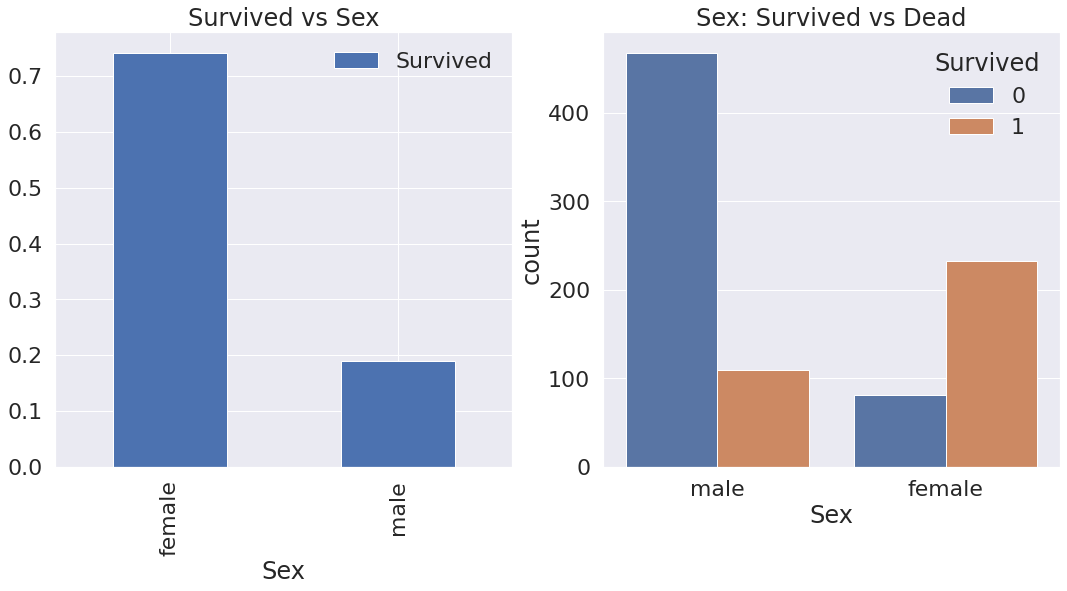

In [ ]:
f, ax = plt.subplots(1,2, figsize=(18,8))
data[['Sex', 'Survived']].groupby(['Sex']).mean().plot.bar(ax=ax[0])
ax[0].set_title('Survived vs Sex')
ax[0].set_yticks(np.arange(0, 0.8, 0.1))
sns.countplot('Sex', data=data, hue='Survived', ax=ax[1])
ax[1].set_title('Sex: Survived vs Dead')

* 배에 있는 남성의 수는 여성보다 훨씬 많다
* 그럼에도 살아남은 여성의 수는 남성의 약 2배이다
* 매우 중요한 feature로 보인다.


#### Pclass -> Ordinal Feature

In [ ]:
pd.crosstab(data['Pclass'], data['Survived'], margins=True).style.background_gradient(cmap='summer_r')

Survived,0,1,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


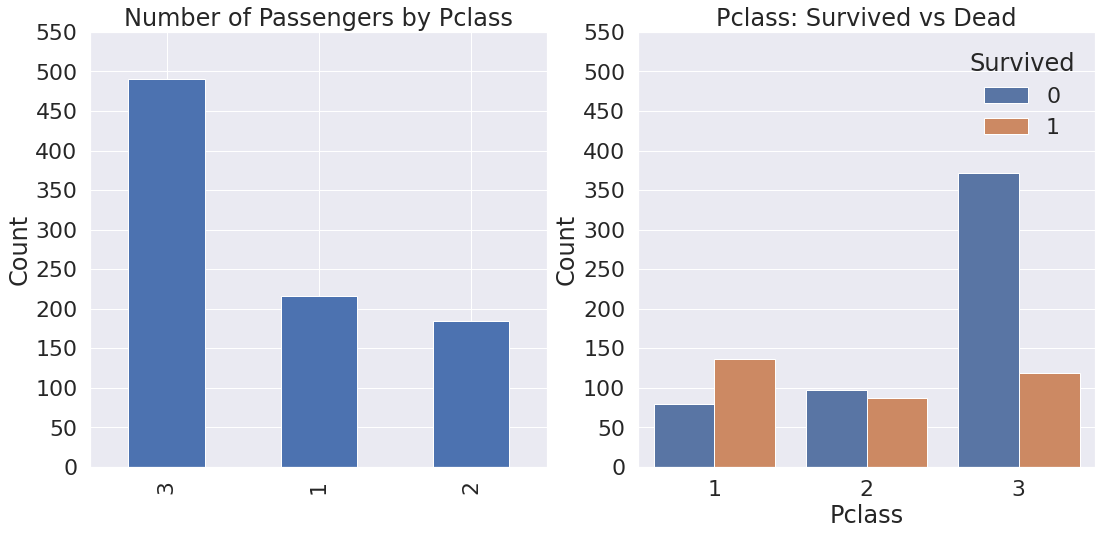

In [ ]:
f, ax = plt.subplots(1,2, figsize=(18,8))
data['Pclass'].value_counts().plot.bar(ax=ax[0])
ax[0].set_title('Number of Passengers by Pclass')
ax[0].set_ylabel('Count')
ax[0].set_yticks(range(0,600, 50))
sns.countplot('Pclass', data= data, hue='Survived', ax=ax[1])
ax[1].set_title('Pclass: Survived vs Dead')
ax[1].set_ylabel('Count')
ax[1].set_yticks(range(0, 600, 50));

* Pclass가 1인 승객의 생존율이높다
* Pclass가 3인 승객이 가장 많지만 생존율은 가장 낮다
* 좀더 들어가서 Sex와 Pclass로 생존ㅇ율을 확인해보다

In [ ]:
pd.crosstab([data.Sex, data.Survived], data["Pclass"], margins=True).style.background_gradient(cmap='summer_r')

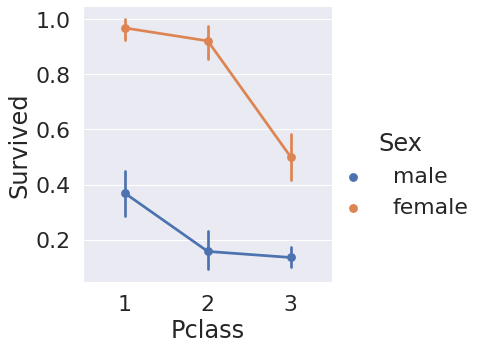

In [ ]:
sns.factorplot('Pclass', 'Survived', hue='Sex', data= data)

* 이 경우 Factorplot을 사용하면 범주형 값을 쉽게 분리할 수 있다.
* Crosstab과 Factorplot을 보면 Pclass1의 여성 94명중 3명만 사망했기 때문에 Pclass1 여성의 생존율이 95%임을 쉽게 추론 할 수 있다.
* Pclass 에 관계없이 구조하는 동안 여성이 최우선 순위를 가졌음이 분명하다. Pclass1의 남성조차도 생존율이 매우 낮다.
* Pclass 도 중요한 기능인것 같다

### Age -> Continous Feature

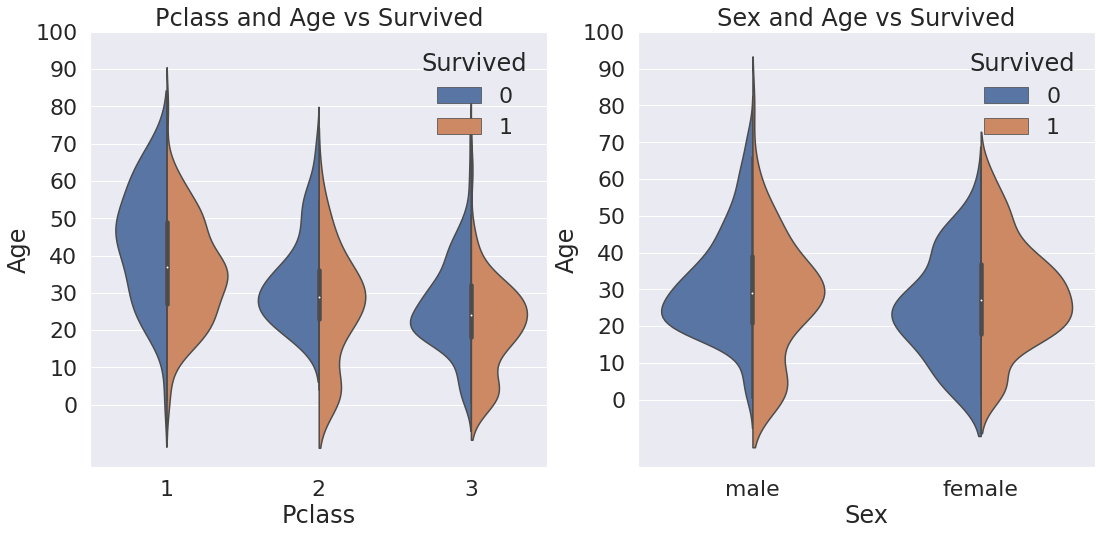

In [ ]:
f, ax= plt.subplots(1,2, figsize=(18,8))
sns.violinplot('Pclass', 'Age', hue='Survived', ax=ax[0], data=data, split=True)
ax[0].set_title('Pclass and Age vs Survived')
ax[0].set_yticks(range(0,110,10))
sns.violinplot('Sex', 'Age', hue='Survived', split=True, data=data, ax=ax[1])
ax[1].set_title('Sex and Age vs Survived')
ax[1].set_yticks(range(0,110,10));

* Pclass에 따라 어린이의 수가 증가하고 10세 미만의 행인 (즉, 어린이)의 생존율은 Pclass에 관계없이 양호해보인다.
* Pclas1의 경우 20-50세의 생존율이 높고, 여성에게 더 높습니다.
* 앞서 본 것처럼 Age 에는 177개의 null값이 있습니다. 이러한 NaN 값을 대체하기 위해 데이터의 평균연령을 할당 할 수 있다.
* 하지만 문제는 다양한 연령대의 사람이 ㅁ낳다는 것이다. 승객의 연령대를 괜찮가 추측하는 방법이 있을까?
* Name Feature를 보면 됩니다. 이름에 Mr 또는 Mrs와 같은 이니셜이 있음을 알수 있습니다. 따라서 Mr 및 Mrs의 평균값을 각 그룹에 할당 할 수 있다.

In [ ]:
data['Initial']=0
for i in data:
  data['Initial']=data.Name.str.extract('([A-Za-z]+)\.') # 이니셜추출

A-Z 또는 a-z사이에 있고 뒤에 . 이오는 문자열을 찾는다. 그래서 우리는 이름에 이니셜을 성공적으로 추출했다

In [ ]:
pd.crosstab(data.Initial, data.Sex).T.style.background_gradient(cmap='summer_r')

Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


Mile또는 Mme와 같이 Miss를 나타내는 잘못된 이니셜이 있다. 다른 값에 대해서는 Miss로 바꾸고 동일 한 것으로 대체하겠다.

In [ ]:
data['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr'],inplace=True)

In [ ]:
data.groupby('Initial')['Age'].mean()

Initial
Master     4.574167
Miss      21.860000
Mr        32.739609
Mrs       35.981818
Other     45.888889
Name: Age, dtype: float64

### filling NaN Ages

In [ ]:
# 각 평균으로 데이터를 채운다
data.loc[(data.Age.isnull())&(data.Initial=='Mr'),'Age']=33
data.loc[(data.Age.isnull())&(data.Initial=='Mrs'),'Age']=36
data.loc[(data.Age.isnull())&(data.Initial=='Master'),'Age']=5
data.loc[(data.Age.isnull())&(data.Initial=='Miss'),'Age']=22
data.loc[(data.Age.isnull())&(data.Initial=='Other'),'Age']=46

In [ ]:
data.Age.isnull().any() # NaN 이 없다

False

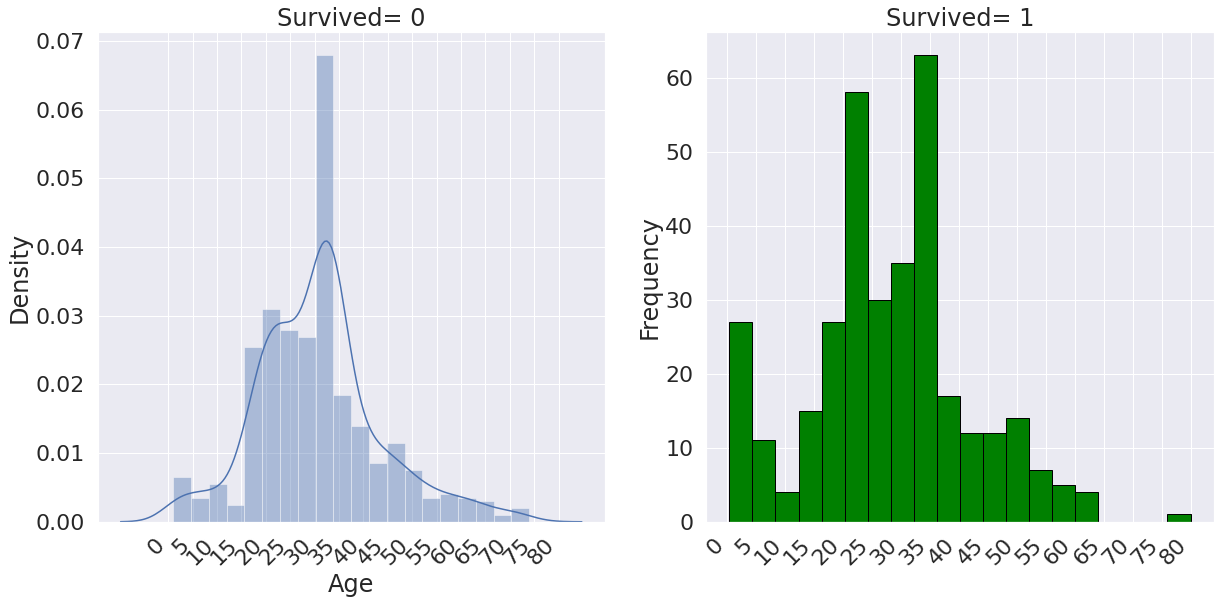

In [ ]:
f,ax=plt.subplots(1,2,figsize=(20,10))
#data[data['Survived']==0].Age.plot.hist(ax=ax[0],bins=20,edgecolor='black',color='red')
sns.distplot(data[data['Survived']==0]['Age'], bins=20, ax=ax[0])
ax[0].set_title('Survived= 0')
x1=list(range(0,85,5))
ax[0].set_xticks(x1)

data[data['Survived']==1].Age.plot.hist(ax=ax[1],color='green',bins=20,edgecolor='black')
ax[1].set_title('Survived= 1')
x2=list(range(0,85,5))
ax[1].set_xticks(x2)

f.autofmt_xdate (rotation =45)
plt.show()


1) 유아 (5 세 미만)가 대량으로 구제되었습니다 (여성과 아동 우선 정책).

2) 가장 나이 많은 승객이 구해졌습니다 (80 년).

3) 최대 사망자 수는 30-40 세였다.

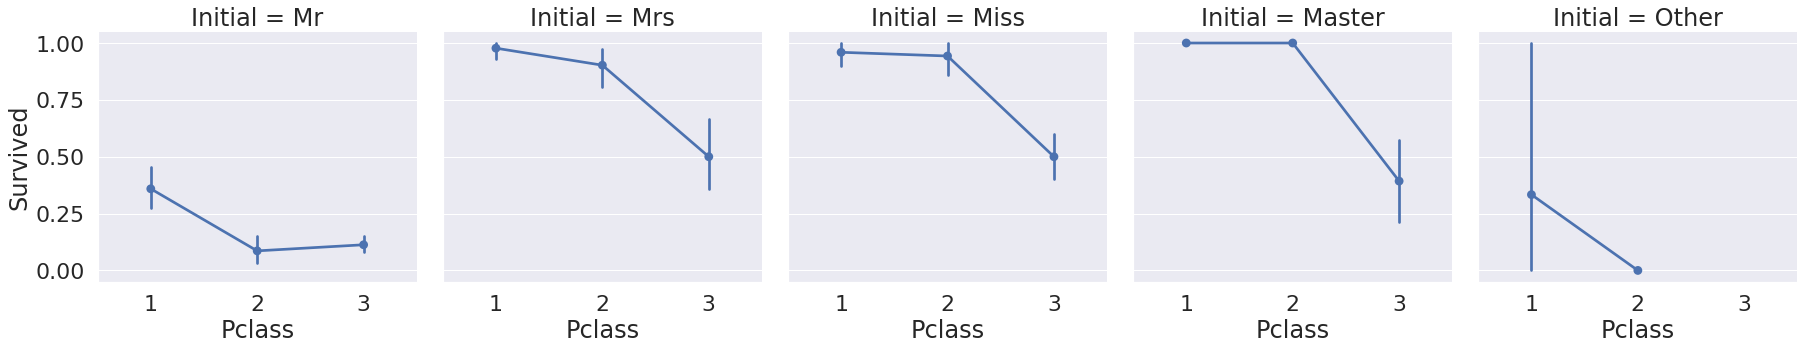

In [ ]:
sns.factorplot('Pclass','Survived',col='Initial',data=data)
plt.show()

여성과 아동 우선 정책은 계급에 관계없이 유효합니다.

### Embarked -> Categorical Value

In [ ]:
pd.crosstab([data.Embarked, data.Pclass],[data.Sex, data.Survived], margins=True).style.background_gradient(cmap='summer_r')

### Embarked에 따른 생존가능성

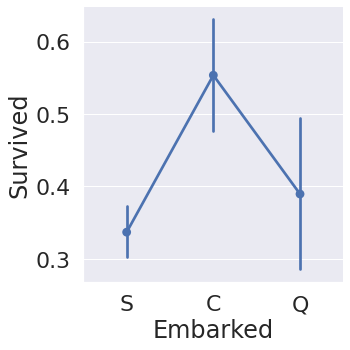

In [ ]:
sns.factorplot('Embarked','Survived', data=data)

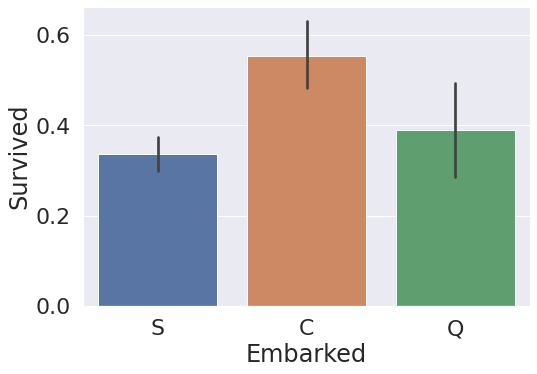

In [ ]:
sns.barplot('Embarked','Survived', data=data)

가장 생존확율이 높은 Embarked는 C(0.55), 가장 낮은 Embarked는 S이다.

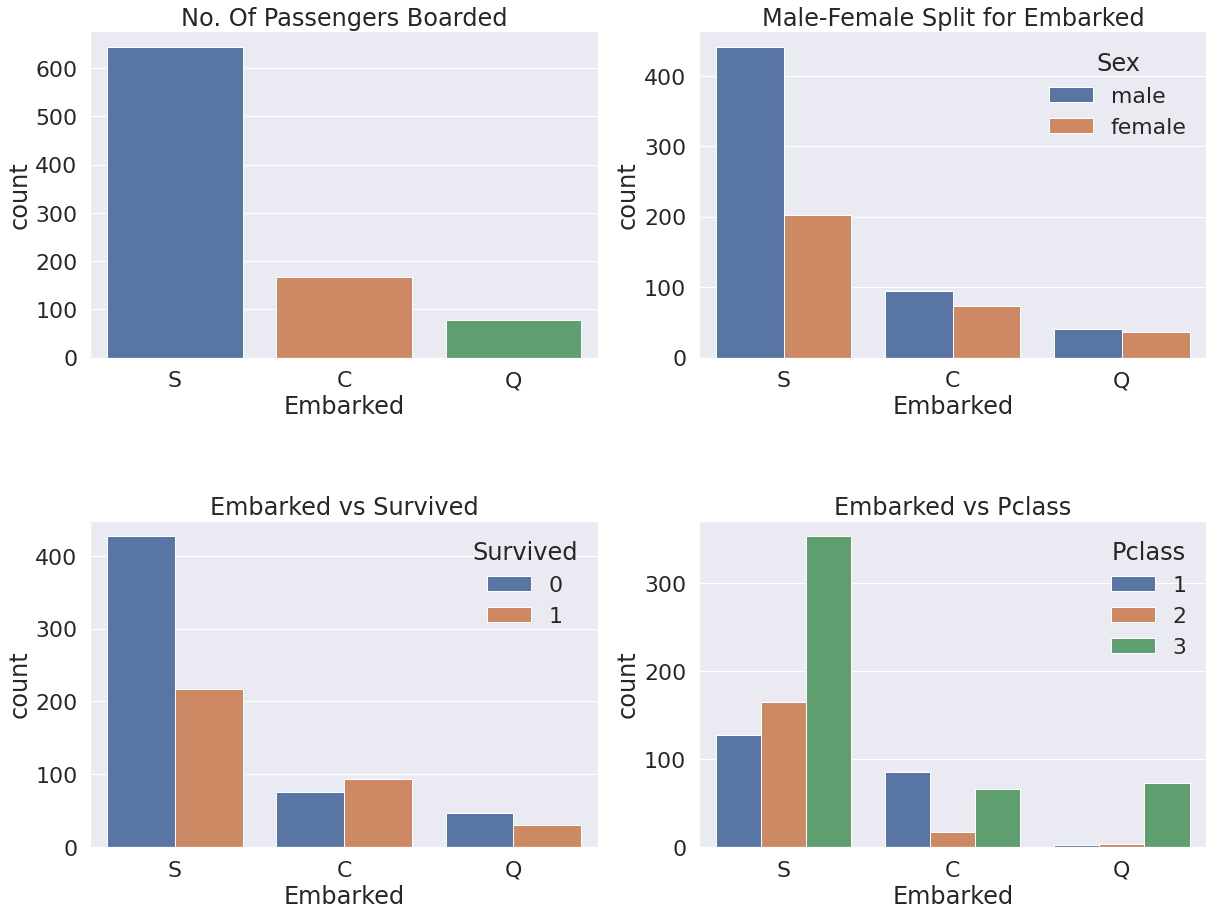

In [ ]:
f,ax=plt.subplots(2,2,figsize=(20,15))
sns.countplot('Embarked',data=data,ax=ax[0,0])
ax[0,0].set_title('No. Of Passengers Boarded')
sns.countplot('Embarked',hue='Sex',data=data,ax=ax[0,1])
ax[0,1].set_title('Male-Female Split for Embarked')
sns.countplot('Embarked',hue='Survived',data=data,ax=ax[1,0])
ax[1,0].set_title('Embarked vs Survived')
sns.countplot('Embarked',hue='Pclass',data=data,ax=ax[1,1])
ax[1,1].set_title('Embarked vs Pclass')
plt.subplots_adjust(wspace=0.2,hspace=0.5)
plt.show()

* 대부분 S 에서 탑승한다.
* C에서 온 승객들이 살아남은 비율이 크다.
* Q는 대부분의 승객이 3클래스 사람이다

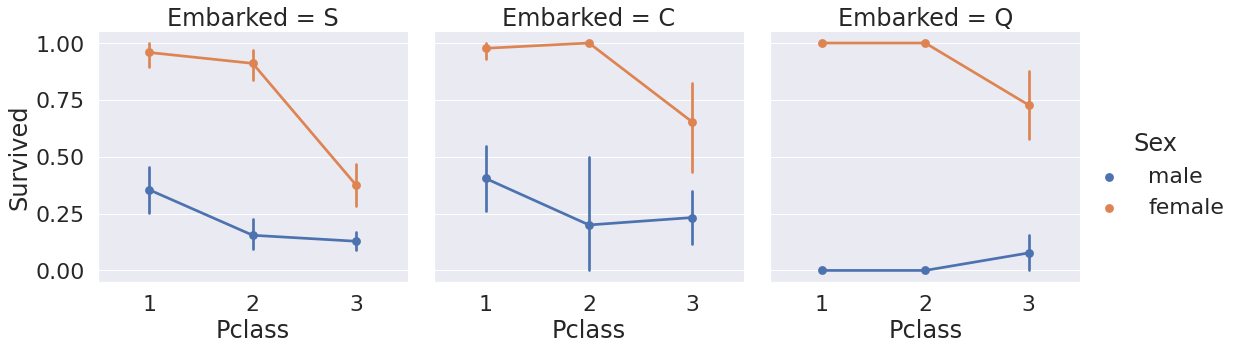

In [ ]:
sns.factorplot('Pclass','Survived',hue='Sex',col='Embarked',data=data)
plt.show()

1) Pclass에 관계없이 Pclass1과 Pclass2의 여성의 생존 확률은 거의 1입니다.            
2) Pclass 3은 남성과 여성 모두에게 생존율이 낮다

### Filling Embarked NaN
Embarked S에서 탄 사람들이 많기에 S로 대체

In [ ]:
data['Embarked'].fillna('S',inplace=True)
data.Embarked.isnull().any()

False

### SibSip -> Discrete Feature

In [ ]:
pd.crosstab(data.SibSp,data.Survived).style.background_gradient(cmap='summer_r')

Survived,0,1
SibSp,,
0,398,210
1,97,112
2,15,13
3,12,4
4,15,3
5,5,0
8,7,0


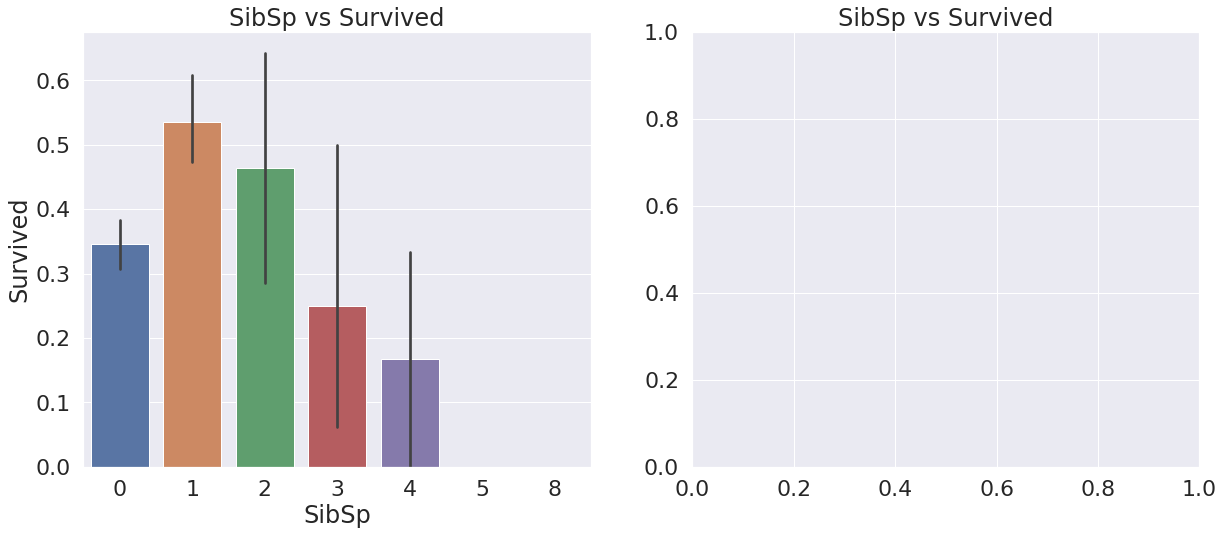

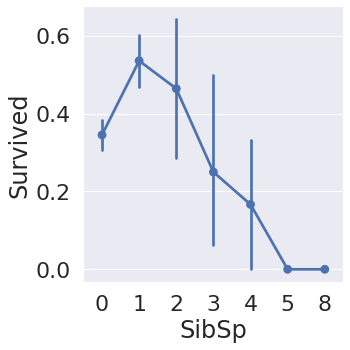

In [ ]:
f,ax=plt.subplots(1,2,figsize=(20,8))
sns.barplot('SibSp','Survived',data=data,ax=ax[0])
ax[0].set_title('SibSp vs Survived')
sns.factorplot('SibSp','Survived',data=data,ax=ax[1])
ax[1].set_title('SibSp vs Survived')
#plt.close(2)
plt.show()

In [ ]:
pd.crosstab(data.SibSp,data.Pclass).style.background_gradient(cmap='summer_r')

Pclass,1,2,3
SibSp,,,
0,137,120,351
1,71,55,83
2,5,8,15
3,3,1,12
4,0,0,18
5,0,0,5
8,0,0,7


형제없이 혼자 탑승 할 경우 생존율이 34.5 %임을 보여줍니다. 형제 자매 수가 증가하면 그래프는 대략 감소합니다. 이것은 의미가 있습니다. 즉, 가족이 있다면 먼저 저를 구하는 대신 그들을 구하려고 노력할 것입니다. 놀랍게도 5-8 인 가족의 생존율은 0 %입니다. 그 이유는 Pclass ??

그 이유는 Pclass입니다. 교차 분석은 SibSp> 3을 가진 Person이 모두 Pclass3에 있음을 보여줍니다. Pclass3 (> 3)의 모든 대가족이 사망했습니다

### Parch

In [ ]:
pd.crosstab(data.Parch,data.Pclass).style.background_gradient(cmap='summer_r')

Pclass,1,2,3
Parch,,,
0,163,134,381
1,31,32,55
2,21,16,43
3,0,2,3
4,1,0,3
5,0,0,5
6,0,0,1


대가족은 class 3에 있는 것을 볼 수 있다.

Text(0.5, 1.0, 'Parch vs Survived')

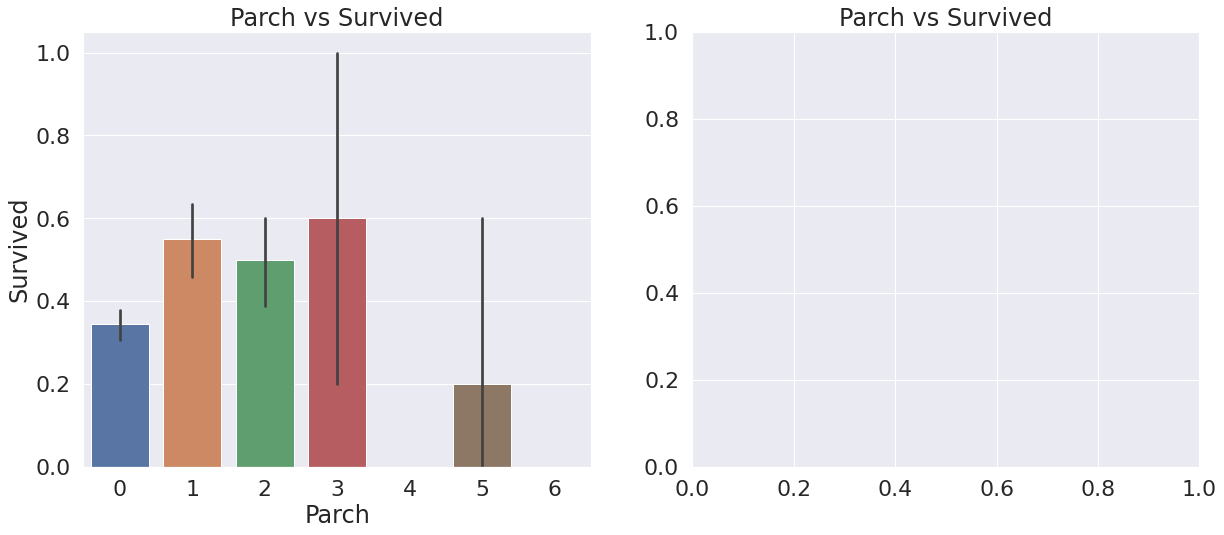

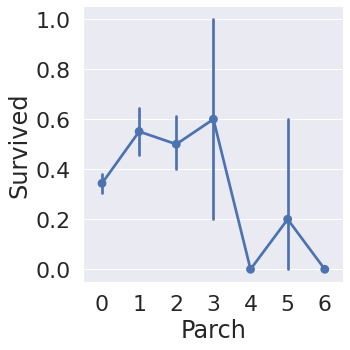

In [ ]:
f,ax=plt.subplots(1,2,figsize=(20,8))
sns.barplot('Parch','Survived',data=data,ax=ax[0])
ax[0].set_title('Parch vs Survived')
sns.factorplot('Parch','Survived',data=data,ax=ax[1])
ax[1].set_title('Parch vs Survived')
#plt.close(2)

여기에서도 결과는 매우 유사합니다. 부모와 함께 탑승 한 승객은 생존 가능성이 더 높습니다. 그러나 숫자가 증가함에 따라 감소합니다.

생존 가능성은 배에 1-3 명의 부모가있는 사람에게 좋습니다. 혼자있는 것은 또한 치명적이며 누군가가 배에 4 명 이상의 부모가있을 때 생존 가능성이 줄어 듭니다.

### Fare--> Continous Feature

In [ ]:
print('Highest Fare was:',data['Fare'].max())
print('Lowest Fare was:',data['Fare'].min())
print('Average Fare was:',data['Fare'].mean())

Highest Fare was: 512.3292
Lowest Fare was: 0.0
Average Fare was: 32.2042079685746


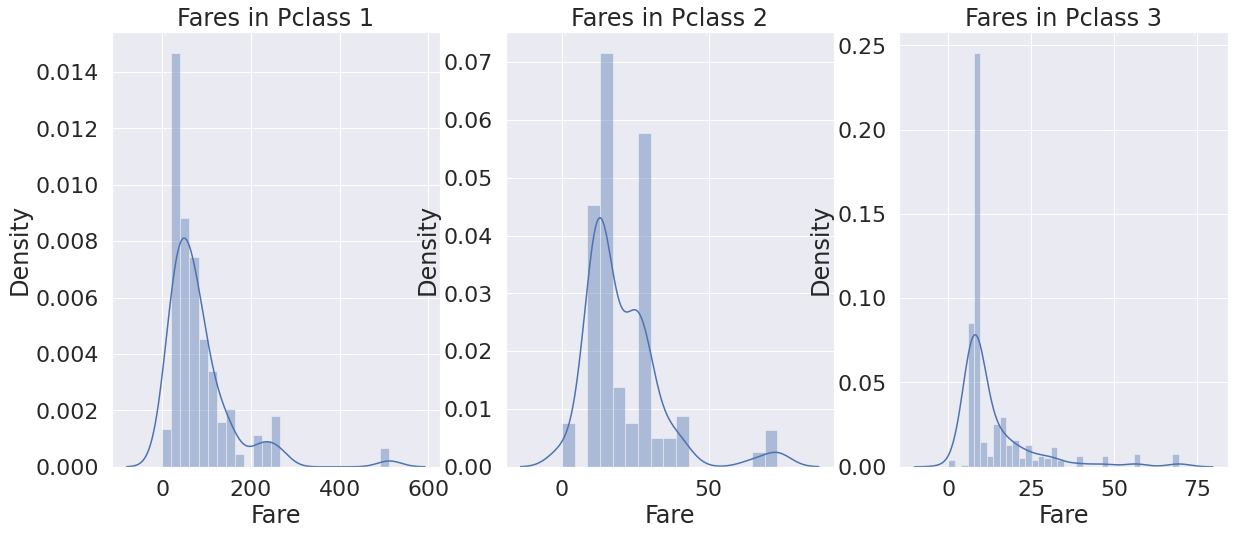

In [ ]:
f,ax=plt.subplots(1,3,figsize=(20,8))
sns.distplot(data[data['Pclass']==1].Fare,ax=ax[0])
ax[0].set_title('Fares in Pclass 1')
sns.distplot(data[data['Pclass']==2].Fare,ax=ax[1])
ax[1].set_title('Fares in Pclass 2')
sns.distplot(data[data['Pclass']==3].Fare,ax=ax[2])
ax[2].set_title('Fares in Pclass 3')
plt.show()

Pclass1의 승객 요금에 큰 분포가있는 것으로 보이며이 분포는 표준이 감소함에 따라 계속 감소합니다.

feature정리

Sex : 여성의 생존 가능성은 남성에 비해 높습니다.

Pclass : 1 등석 승객이되는 것이 더 나은 생존 기회를 제공한다는 가시적 인 경향이 있습니다. Pclass3의 생존율은 매우 낮습니다. 여성의 경우 Pclass1의 생존 확률은 거의 1이며 Pclass2의 생존 확률도 높습니다. 돈이 이긴다 !!!.

Age : 5-10 세 미만의 어린이는 생존 가능성이 높습니다. 15 세에서 35 세 사이의 승객들이 많이 사망했습니다.

Embarked : 이것은 매우 흥미로운 기능입니다. C에서의 생존 가능성은 대부분의 Pclass1 승객이 S에서 일어 났음에도 불구하고 더 나은 것으로 보입니다. Q의 승객은 모두 Pclass3 출신이었습니다.

Parch + SibSp : 1-2 명의 형제 자매, 배우자 또는 1-3 명의 부모가있는 경우 혼자 있거나 대가족이 함께 여행하는 것보다 확률이 더 높습니다.

### 상관관계

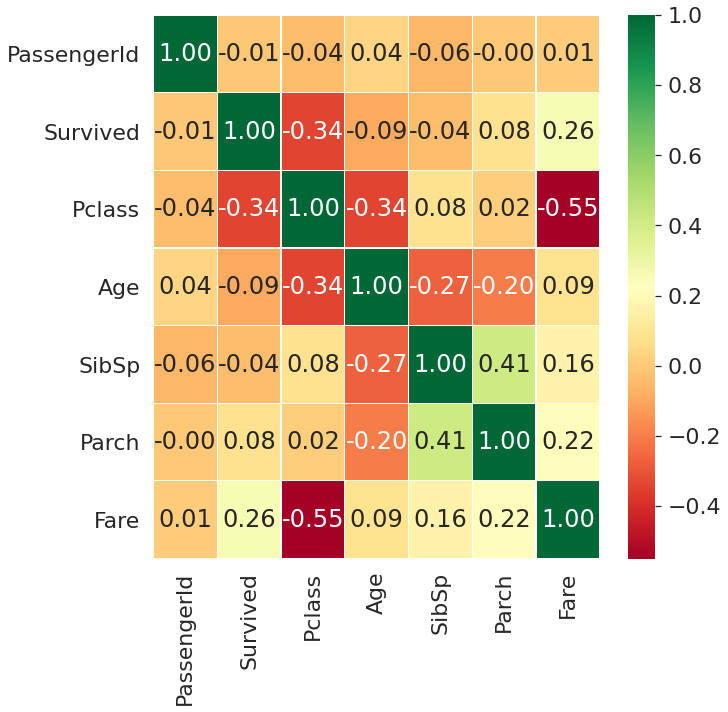

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(data.corr(), annot= True, cmap='RdYlGn', linewidths=0.2, fmt='.2f')
#fig=plt.gcf()
#fig.set_size_inches(15,15)
plt.show()

가장 먼저 주목해야 할 것은 알파벳이나 문자열 사이의 상관 관계가 없다는 것이 명백하기 때문에 숫자 특성 만 비교된다는 것입니다.      

양의 상관 관계 : 기능 A의 증가가 기능 B의 증가로 이어지는 경우 양의 상관 관계가 있습니다. 값 1은 완벽한 양의 상관 관계를 의미합니다.

음의 상관 관계 : 기능 A의 증가가 기능 B의 감소로 이어지는 경우 음의 상관 관계입니다. 값 -1은 완벽한 음의 상관 관계를 의미합니다.

본래 상관관계가 높은 feature가 중복되면 중복을 제거해야합니다. 하지만 위의 corr을 보면 강한 상관관계를 갖는 feature는 없으므로 모두 사용하겠습니다.

## 2. Feature Engineering and Data Cleaning

모든 feature를 사용 할 필요는 없습니다. 제거해야할 중복 feature가 많이 있을수도 있습니다. 또한 다른 featuer에서 정보를 추출하여 새로운 feature를 만들 수 도 있습니다.

예를 들어 Name을 이용해 Initials를 가져온것 처럼 새로운 feature를 만들 수 있습니다. 새로운 feature를 얻고 중복되는 feature를 삭제할 수 있는지 확인해 보겠습니다. 

또한 feature들을 모델에 넣을 수 있는 형태로 변환하겠습니다

### Age_band
나이는 연속적인 변수이므로 그대로 사용하기에는 문제가 있습니다.

이러한 연속값을 binning 또는 정규화를 통해 범주값으로 변환해야 합니다.

승객의 최대 연령은 80입니다. 이를 5개의 bin으로 나누면 16입니다. 따라서 bin의 크기는 16입니다

In [ ]:
data['Age_band']=0
data.loc[data['Age']<=16,'Age_band']=0
data.loc[(data['Age']>16)&(data['Age']<=32),'Age_band']=1
data.loc[(data['Age']>32)&(data['Age']<=48),'Age_band']=2
data.loc[(data['Age']>48)&(data['Age']<=64),'Age_band']=3
data.loc[data['Age']>64,'Age_band']=4
data.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,Age_band
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,2


In [ ]:
data['Age_band'].value_counts().to_frame().style.background_gradient(cmap='summer')

,Age_band
1,382
2,325
0,104
3,69
4,11


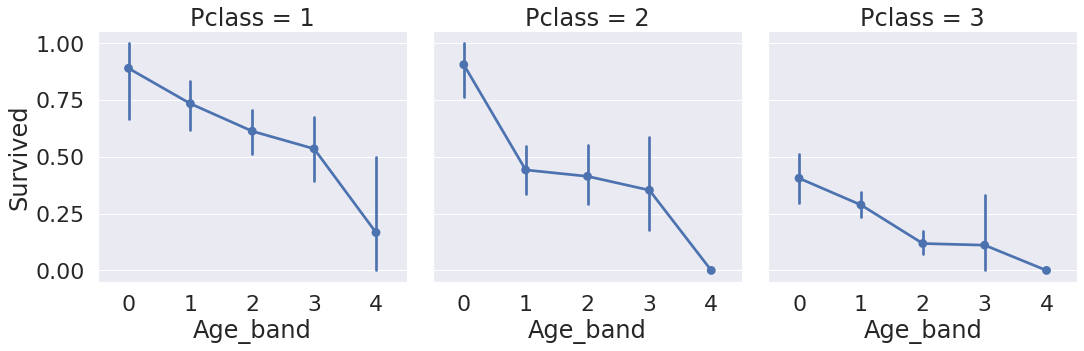

In [ ]:
sns.factorplot('Age_band', 'Survived', data=data, col='Pclass')

Pclass에 상관없이 나이가듬에 따라 생존률이 감소한다

### Family_Size and Alone
이 feature는 Parch 와 SibSp의 요약입니다. 생존율이 가족 규모와 관계가 있는지 확인할 수 있도록 결합 된 데이터를 제공합니다. Alone은 승객이 혼자인지 아닌지를 나타냅니다

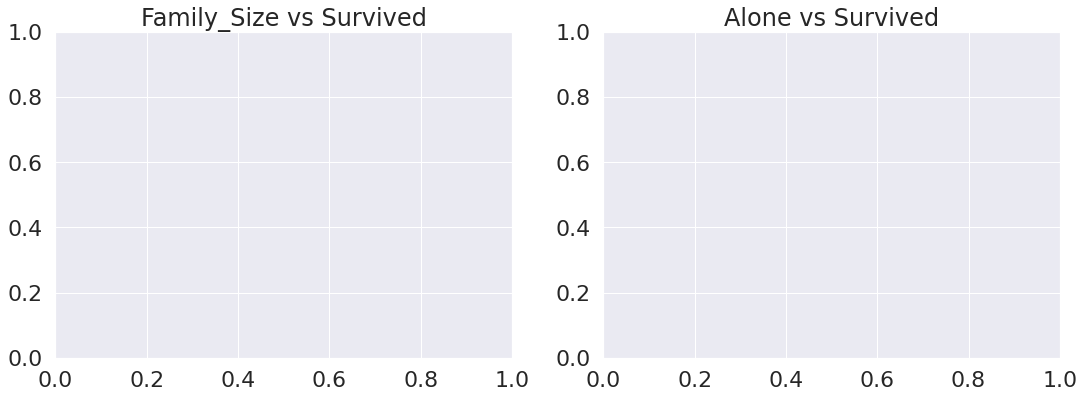

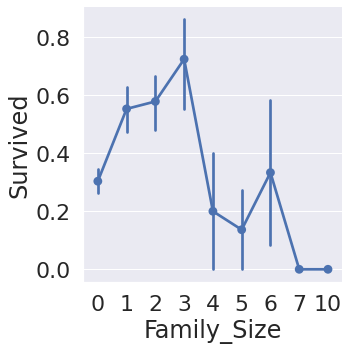

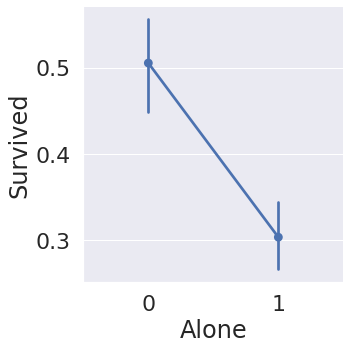

In [ ]:
data['Family_Size']=0
data['Family_Size']=data['Parch']+data['SibSp']#family size
data['Alone']=0
data.loc[data.Family_Size==0,'Alone']=1#Alone

f,ax=plt.subplots(1,2,figsize=(18,6))
sns.factorplot('Family_Size','Survived',data=data,ax=ax[0])
ax[0].set_title('Family_Size vs Survived')
sns.factorplot('Alone','Survived',data=data,ax=ax[1])
ax[1].set_title('Alone vs Survived')

plt.show()

Text(0.5, 1.0, 'Alone vs Survived')

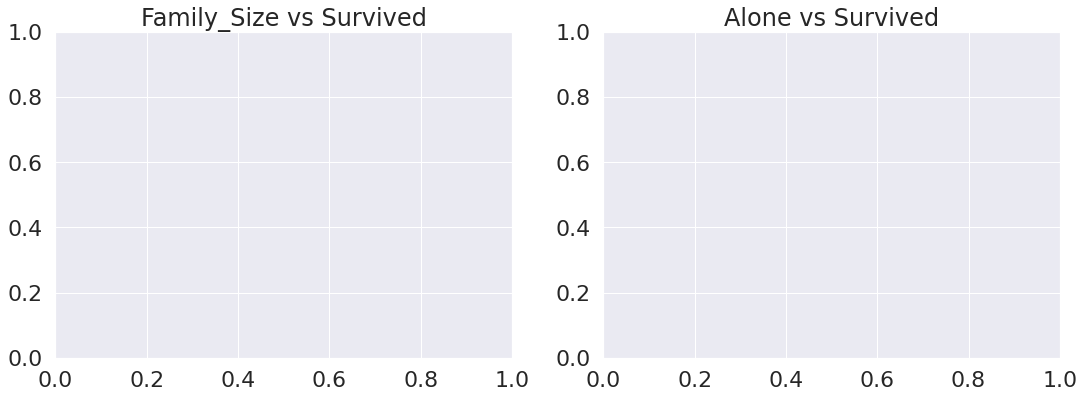

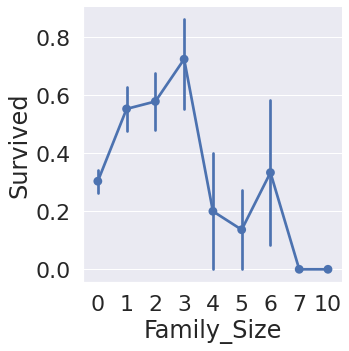

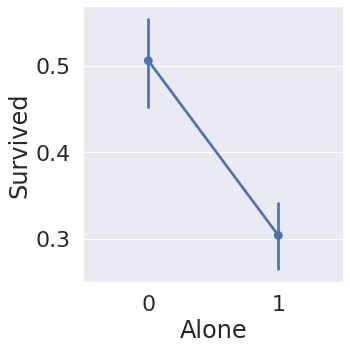

In [ ]:
f,ax=plt.subplots(1,2,figsize=(18,6))
sns.catplot('Family_Size','Survived',data=data,ax=ax[0], kind='point')
ax[0].set_title('Family_Size vs Survived')
sns.catplot('Alone','Survived',data=data,ax=ax[1], kind='point')
ax[1].set_title('Alone vs Survived')

Family_Size = 0은 통행인이 혼자임을 의미합니다. 분명히 혼자이거나 family_size = 0이면 생존 가능성이 매우 낮습니다. 가족 수> 4 인 경우 기회도 감소합니다. 이것은 또한 모델의 중요한 기능으로 보입니다. 더 자세히 살펴 보겠습니다.

In [ ]:
sns.factorplot('Alone','Survived',data=data,hue='Sex',col='Pclass')
plt.show()

가족이있는 여성보다 혼자있는 여성의 확률이 높은 Pclass3를 제외하고는 혼자있는 것이 성별이나 Pclass에 관계없이 생존율이 낮습니다

### Fare_Range
Fare은 또한 연속적인 기능이므로이를 서수 값으로 변환해야합니다. 이를 위해 pandas.qcut을 사용합니다.

qcut이하는 일은 우리가 통과 한 빈의 수에 따라 값을 분할하거나 배열하는 것입니다. 따라서 5 개의 빈을 전달하면 5 개의 별도 빈 또는 값 범위에 균등 한 간격으로 값이 정렬됩니다.

In [ ]:
data['Fare_Range']=pd.qcut(data['Fare'],4)
data.groupby(['Fare_Range'])['Survived'].mean().to_frame().style.background_gradient(cmap='summer_r')

,Survived
Fare_Range,
"(-0.001, 7.91]",0.197309
"(7.91, 14.454]",0.303571
"(14.454, 31.0]",0.454955
"(31.0, 512.329]",0.581081


 fare_range가 증가할수록 생존 가능성이 증가한다는 것을 분명히 알 수 있습니다.

하지만 Fare_Range 값을 그대로 전달할 수 없습니다. Age_Band에서했던 것과 같은 단일 값으로 변환해야합니다.

In [ ]:
data['Fare_cat']=0
data.loc[data['Fare']<=7.91,'Fare_cat']=0
data.loc[(data['Fare']>7.91)&(data['Fare']<=14.454),'Fare_cat']=1
data.loc[(data['Fare']>14.454)&(data['Fare']<=31),'Fare_cat']=2
data.loc[(data['Fare']>31)&(data['Fare']<=513),'Fare_cat']=3

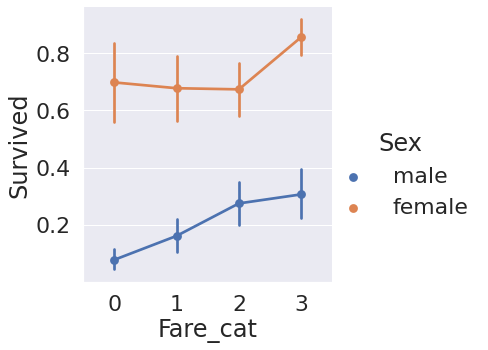

In [ ]:
sns.factorplot('Fare_cat','Survived',data=data,hue='Sex')
plt.show()

### String values to Numeric
기계 학습 모델에 문자열을 전달할 수 없기 때문에 성, Embarked 등의 특성을 숫자 값으로 변환해야합니다.

In [ ]:
data['Sex'].replace(['male','female'],[0,1],inplace=True)
data['Embarked'].replace(['S','C','Q'],[0,1,2],inplace=True)
data['Initial'].replace(['Mr','Mrs','Miss','Master','Other'],[0,1,2,3,4],inplace=True)

### 불필요한 feature 삭제
Name-> 카테고리 값으로 변환 할 수 없으므로 이름 기능이 필요하지 않습니다.

Age-> Age_band 기능이 있으므로 필요하지 않습니다.

Ticket-> 분류 할 수없는 임의의 문자열입니다.

Fare-> Fare_cat 기능이 있으므로 필요하지 않습니다.

Cabin-> 많은 NaN 값과 많은 승객이 여러 개의 캐빈을 가지고 있습니다. 그래서 이것은 쓸모없는 기능입니다.

Fare_Range-> fare_cat 기능이 있습니다.

PassengerId-> 분류 할 수 없습니다.

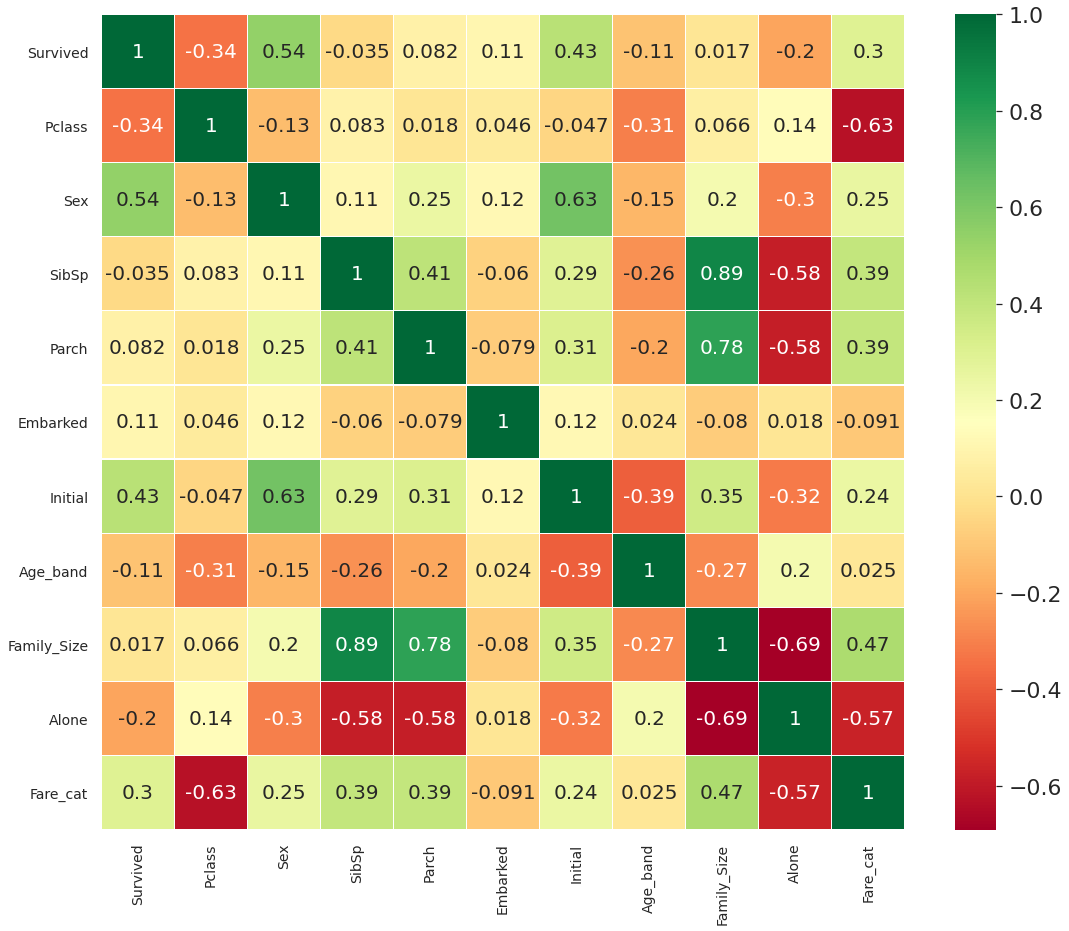

In [ ]:
data.drop(['Name','Age','Ticket','Fare','Cabin','Fare_Range','PassengerId'],axis=1,inplace=True)
sns.heatmap(data.corr(),annot=True,cmap='RdYlGn',linewidths=0.2,annot_kws={'size':20})
fig=plt.gcf()
fig.set_size_inches(18,15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()


상관 관계 플롯에서 관련된 feature 들을 볼 수 있습니다. SibSp 와 Family_Size , Parch 와 Family_Size는 긍정적이며  
Alone 및 Family_Size는 부정적인 것을 볼 수 있습니다.

# 3. Predictive Modeling

우리는 EDA 부분에서 몇 가지 통찰력을 얻었습니다. 하지만 그것으로는 승객이 살아남을 것인지 죽을 것인지 정확하게 예측하거나 말할 수 없습니다. 

이제 우리는 훌륭한 분류 알고리즘을 사용하여 승객의 생존 여부를 예측할 것입니다. 다음은 모델을 만드는 데 사용할 알고리즘입니다.

1)Logistic Regression

2)Support Vector Machines(Linear and radial)

3)Random Forest

4)K-Nearest Neighbours

5)Naive Bayes

6)Decision Tree

7)Logistic Regression

In [ ]:
# 머신러닝 패키지 import
from sklearn.linear_model import LogisticRegression #logistic regression
from sklearn import svm #support vector Machine
from sklearn.ensemble import RandomForestClassifier #Random Forest
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.naive_bayes import GaussianNB #Naive bayes
from sklearn.tree import DecisionTreeClassifier #Decision Tree
from sklearn.model_selection import train_test_split #training and testing data split
from sklearn import metrics #accuracy measure
from sklearn.metrics import confusion_matrix #for confusion matrix

In [ ]:
data.columns

Index(['Survived', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'Initial',
       'Age_band', 'Family_Size', 'Alone', 'Fare_cat'],
      dtype='object')

In [ ]:
train,test=train_test_split(data,test_size=0.3,random_state=0,stratify=data['Survived'])
train_X=train[train.columns[1:]]
train_Y=train[train.columns[:1]]
test_X=test[test.columns[1:]]
test_Y=test[test.columns[:1]]
X=data[data.columns[1:]]
Y=data['Survived']

### Radial Support Vector Machines(rbf-SVM)

In [ ]:
model = svm.SVC(kernel = 'rbf', C=1, gamma=0.1)
model.fit(train_X, train_Y)
prediction1 = model.predict(test_X)
print('Accuracy for rbf SVM is ', metrics.accuracy_score(prediction1, test_Y))

Accuracy for rbf SVM is  0.835820895522388


### Linear Support Vector Machine(linear-SVM)

In [ ]:
model=svm.SVC(kernel='linear',C=0.1,gamma=0.1)
model.fit(train_X,train_Y)
prediction2=model.predict(test_X)
print('Accuracy for linear SVM is',metrics.accuracy_score(prediction2,test_Y))

Accuracy for linear SVM is 0.8171641791044776


### Logistic Regression

In [ ]:
model = LogisticRegression()
model.fit(train_X,train_Y)
prediction3=model.predict(test_X)
print('The accuracy of the Logistic Regression is',metrics.accuracy_score(prediction3,test_Y))

The accuracy of the Logistic Regression is 0.8134328358208955


### Decision Tree

In [ ]:
model=DecisionTreeClassifier()
model.fit(train_X,train_Y)
prediction4=model.predict(test_X)
print('The accuracy of the Decision Tree is',metrics.accuracy_score(prediction4,test_Y))

The accuracy of the Decision Tree is 0.8022388059701493


### K-Nearest Neighbours(KNN)

In [ ]:
model=KNeighborsClassifier() 
model.fit(train_X,train_Y)
prediction5=model.predict(test_X)
print('The accuracy of the KNN is',metrics.accuracy_score(prediction5,test_Y))

n_neighbors의 속성값을 변경하면 KNN모델의 정확도가 변경됩니다. 기본값은 5 입니다.

n_neighbors의 다양한 값에 대한 정확도를 확인해보겠습니다

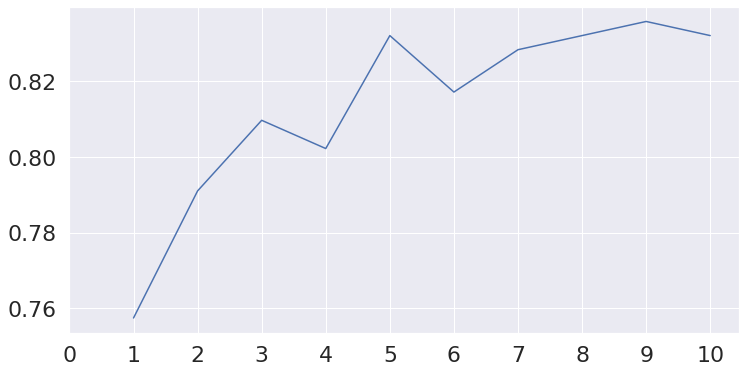

Accuracies for different values of n are: [0.75746269 0.79104478 0.80970149 0.80223881 0.83208955 0.81716418
 0.82835821 0.83208955 0.8358209  0.83208955] with the max value as  0.835820895522388


In [ ]:
a_index = list(range(1,11))
a=pd.Series()
x=[0,1,2,3,4,5,6,7,8,9,10]
for i in list(range(1,11)):
  model=KNeighborsClassifier(n_neighbors=i)
  model.fit(train_X, train_Y)
  prediction=model.predict(test_X)
  a=a.append(pd.Series(metrics.accuracy_score(prediction, test_Y)))
  # 0.832089 값을 Series로 만들면 인덱스가 생겨서  0    0.83209 가 된다.
  # Series의 append는 list의 append와 다르다
  # Series의 append는 위, 아래로 합쳐주는 기능이다.
  # 기존의 것에 합친 뒤 받아줘야 반영이 된다.
plt.plot(a_index, a)
plt.xticks(x)
fig=plt.gcf()
fig.set_size_inches(12,6)
plt.show()
print('Accuracies for different values of n are:',a.values,'with the max value as ',a.values.max())

### Gaussian Naive Bayes

In [ ]:
model=GaussianNB()
model.fit(train_X,train_Y)
prediction6=model.predict(test_X)
print('The accuracy of the NaiveBayes is',metrics.accuracy_score(prediction6,test_Y))

The accuracy of the NaiveBayes is 0.8134328358208955


### Random Forests

In [ ]:
model=RandomForestClassifier(n_estimators=100)
model.fit(train_X,train_Y)
prediction7=model.predict(test_X)
print('The accuracy of the Random Forests is',metrics.accuracy_score(prediction7,test_Y))

The accuracy of the Random Forests is 0.8208955223880597


모델의 정확성이 분류기의 견고성을 결정하는 유일한 요소는 아닙니다. 분류 기가 훈련 데이터에 대해 훈련되고 테스트 데이터에 대해 테스트되고 90 %의 정확도를 기록한다고 가정 해 보겠습니다.

매우 좋은 정확도로 보이지만, 모든 새로운 테스트 세트에 대해 90 %가 될 것임을 확인할 수 없습니다.     
분류자가 자신을 훈련하는 데 사용할 모든 인스턴스를 결정할 수 없기 때문입니다. 훈련 및 테스트 데이터가 변경되면 정확도도 변경됩니다. 증가하거나 감소 할 수 있습니다. 이를 모델 분산이라고합니다.     

이를 극복하고 일반화된 모델을 얻기 위해 교차검증을 사용합니다

## Cross Validation
데이터의 불균형은 빈번하게 일어납니다.     
따라서 데이터 세트의 모든 인스턴스에 대해 알고리즘을 훈련하고 테스트해야합니다. 그런 다음 데이터 세트에 대해 기록 된 모든 정확도의 평균을 구할 수 있습니다.

1) K-Fold Cross Validation은 먼저 데이터 세트를 k-subset으로 나누는 방식으로 작동합니다.

2) 데이터 세트를 (k = 5) 부분으로 나눈다 고 가정 해 보겠습니다. 테스트를 위해 1 개 부분을 사용하고 4 개 부분에 대해 알고리즘을 훈련합니다.

3) 각 반복에서 테스트 부분을 변경하고 다른 부분에 대해 알고리즘을 학습합니다. 그런 다음 정확도와 오류를 평균내어 알고리즘의 평균 정확도를 얻습니다.

이를 K-Fold Cross Validation이라고합니다.

4) 알고리즘은 일부 훈련 데이터의 경우 데이터 세트에 대해 과소 적합 할 수 있으며 때로는 다른 훈련 세트의 데이터를 과적 합할 수도 있습니다. 따라서 교차 검증을 통해 일반화 된 모델을 얻을 수 있습니다.

In [ ]:
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction
kfold = KFold(n_splits=10, random_state=22) # k=10, split the data into 10 equal parts
xyz=[]
accuracy=[]
std=[]
classifiers=['Linear Svm','Radial Svm','Logistic Regression','KNN','Decision Tree','Naive Bayes','Random Forest']
models=[svm.SVC(kernel='linear'),svm.SVC(kernel='rbf'),LogisticRegression(),KNeighborsClassifier(n_neighbors=9),DecisionTreeClassifier(),GaussianNB(),RandomForestClassifier(n_estimators=100)]
for i in models:
    model = i
    cv_result = cross_val_score(model,X,Y, cv = kfold,scoring = "accuracy")
    cv_result=cv_result
    xyz.append(cv_result.mean())
    std.append(cv_result.std())
    accuracy.append(cv_result)
new_models_dataframe2=pd.DataFrame({'CV Mean':xyz,'Std':std},index=classifiers)       
new_models_dataframe2

,CV Mean,Std
Linear Svm,0.793471,0.047797
Radial Svm,0.828290,0.034427
Logistic Regression,0.805843,0.024061
KNN,0.813783,0.041210
Decision Tree,0.805893,0.030535
Naive Bayes,0.801386,0.028999
Random Forest,0.815955,0.028380


(array([1, 2, 3, 4, 5, 6, 7]), <a list of 7 Text major ticklabel objects>)

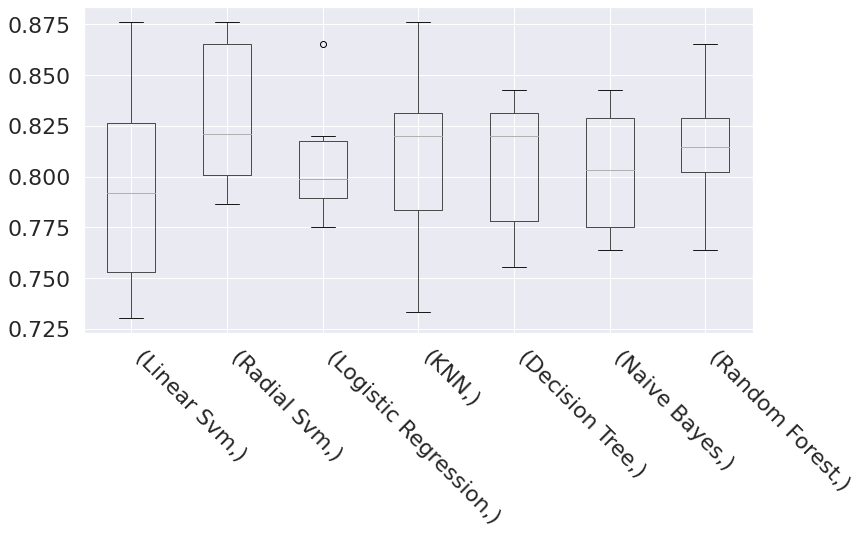

In [ ]:
plt.subplots(figsize=(12,6))
box=pd.DataFrame(accuracy,index=[classifiers])

box.T.boxplot()
plt.xticks(rotation =-45, ha='left')

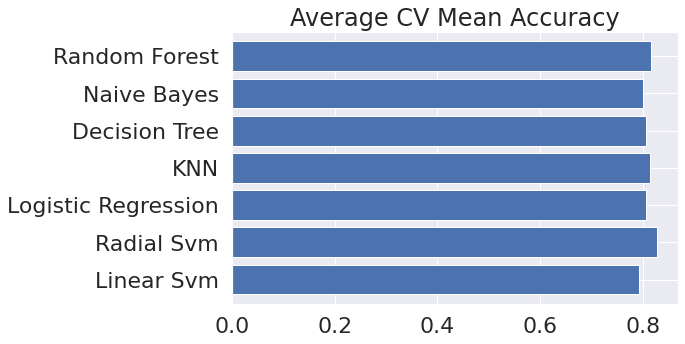

In [ ]:
new_models_dataframe2['CV Mean'].plot.barh(width=0.8)
plt.title("Average CV Mean Accuracy")
fig=plt.gcf()
fig.set_size_inches(8,5)
plt.show()

불균형으로 인해 분류 정확도가 잘못 될 수 습니다.    
모델이 어디에서 잘못되었는지 또는 모델이 잘못 예측한 클래스를 보여주는 Confusion Matrix로 요약된 결과를 얻을 수 있습니다.

## Confusion Matrix
TN, FP      
FN, TP     
정확히 예측했는지 잘못분류 했는지 분류의 수를 제공한다.

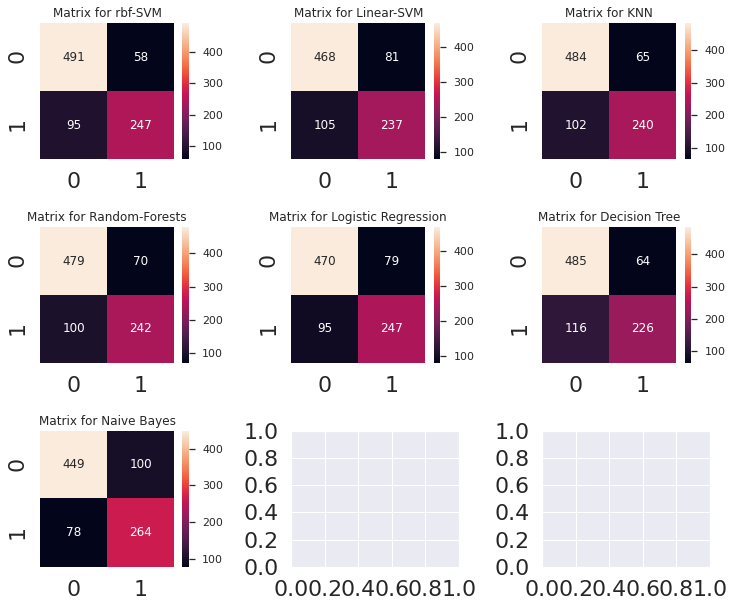

In [ ]:
f,ax=plt.subplots(3,3,figsize=(12,10))
sns.set(font_scale=1)
y_pred = cross_val_predict(svm.SVC(kernel='rbf'),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[0,0],annot=True,fmt='2.0f')
ax[0,0].set_title('Matrix for rbf-SVM')
y_pred = cross_val_predict(svm.SVC(kernel='linear'),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[0,1],annot=True,fmt='2.0f')
ax[0,1].set_title('Matrix for Linear-SVM')
y_pred = cross_val_predict(KNeighborsClassifier(n_neighbors=9),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[0,2],annot=True,fmt='2.0f')
ax[0,2].set_title('Matrix for KNN')
y_pred = cross_val_predict(RandomForestClassifier(n_estimators=100),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[1,0],annot=True,fmt='2.0f')
ax[1,0].set_title('Matrix for Random-Forests')
y_pred = cross_val_predict(LogisticRegression(),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[1,1],annot=True,fmt='2.0f')
ax[1,1].set_title('Matrix for Logistic Regression')
y_pred = cross_val_predict(DecisionTreeClassifier(),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[1,2],annot=True,fmt='2.0f')
ax[1,2].set_title('Matrix for Decision Tree')
y_pred = cross_val_predict(GaussianNB(),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[2,0],annot=True,fmt='2.0f')
ax[2,0].set_title('Matrix for Naive Bayes')
plt.subplots_adjust(hspace=0.5,wspace=0.5)
plt.show()

왼쪽 대각선은 각 클래스에 대한 올바른 예측 수를 보여주고 오른쪽 대각선은 잘못된 예측 수를 보여줍니다. rbf-SVM에 대한 첫 번째 플롯을 고려해 보겠습니다.

정확한 예측의 수는 491 (죽음의 경우) + 247 (생존의 경우)이며 평균 CV 정확도는 (491 + 247) / 891 = 82.8 %입니다.

 58 명의 사망자를 살아남은 것으로 잘못 분류하고 95 명은 죽은 것으로 분류했습니다. 따라서 죽은 것으로 예상하여 더 많은 실수를 저질렀습니다.

 모든 행렬을 살펴보면 rbf-SVM이 죽은 승객을 정확하게 예측할 가능성이 더 높지만 NaiveBayes는 살아남은 승객을 정확하게 예측할 가능성이 더 높다고 말할 수 있습니다.

## Hyper-Parameters Tuning
기계 학습 모델은 블랙 박스와 같습니다. 이 Black-Box에 대한 몇 가지 기본 매개 변수 값이 있으며 더 나은 모델을 얻기 위해 조정하거나 변경할 수 있습니다. SVM 모델의 C 및 감마와 마찬가지로 서로 다른 분류기에 대해 유사하게 다른 매개 변수를 하이퍼 매개 변수라고하며, 알고리즘의 학습률을 변경하고 더 나은 모델을 얻기 위해 조정할 수 있습니다. 이를 Hyper-Parameter Tuning이라고합니다.

우리는 가장 성능이 좋았던 SVM 과 RandomForest의 하이퍼파라미터를 조정해 보겠습니다.

### svm

In [ ]:
from sklearn.model_selection import GridSearchCV
C=[0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
gamma = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
kernel=['rbf']
hyper={'kernel': kernel, 'C':C, 'gamma':gamma}
gd=GridSearchCV(estimator=svm.SVC(), param_grid=hyper, verbose=True)
gd.fit(X,Y)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 5 folds for each of 110 candidates, totalling 550 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.8282593685267716
SVC(C=0.4, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.3, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


[Parallel(n_jobs=1)]: Done 550 out of 550 | elapsed:   12.2s finished


### Random Forests

In [ ]:
n_estimators=range(100,1000,100)
hyper={'n_estimators':n_estimators}
gd=GridSearchCV(estimator=RandomForestClassifier(random_state=0),param_grid=hyper,verbose=True)
gd.fit(X,Y)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:   37.4s finished


0.819327098110602
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


## Ensembling

Ensembling은 모델의 정확성이나 성능을 높이는 좋은 방법입니다. 간단히 말해서, 하나의 강력한 모델을 만들기 위해 다양한 단순 모델의 조합입니다.

Ensembling은 다음과 같은 방법으로 수행 할 수 있습니다.

1)Voting Classifier

2)Bagging

3)Boosting.

### voting Classifier
다양한 단순 기계 학습 모델의 예측을 결합하는 가장 간단한 방법입니다. 모든 하위 모델의 예측을 기반으로 평균 예측 결과를 제공합니다. 하위 모델은 모두 다른 유형입니다.

In [ ]:
from sklearn.ensemble import VotingClassifier
ensemble_lin_rbf=VotingClassifier(estimators=[('KNN',KNeighborsClassifier(n_neighbors=10)),
                                              ('RBF',svm.SVC(probability=True,kernel='rbf',C=0.5,gamma=0.1)),
                                              ('RFor',RandomForestClassifier(n_estimators=500,random_state=0)),
                                              ('LR',LogisticRegression(C=0.05)),
                                              ('DT',DecisionTreeClassifier(random_state=0)),
                                              ('NB',GaussianNB()),
                                              ('svm',svm.SVC(kernel='linear',probability=True))
                                             ], 
                       voting='soft').fit(train_X,train_Y)
print('The accuracy for ensembled model is:',ensemble_lin_rbf.score(test_X,test_Y))
cross=cross_val_score(ensemble_lin_rbf,X,Y, cv = 10,scoring = "accuracy")
print('The cross validated score is',cross.mean())

The accuracy for ensembled model is: 0.8208955223880597
The cross validated score is 0.8249188514357053


### Bagging(Bootstrap Aggregation)
배깅은 일반적인 앙상블 방법입니다. 데이터 세트의 작은 파티션에 유사한 분류기를 적용한 다음 모든 예측의 평균을 구하는 방식으로 작동합니다. 평균화로 인해 분산이 감소합니다.     

voting과 달리 Bagging은 유사한(같은) 분류기를 사용합니다.

작은 데이터셋을 여러개 만들어서 학습시킵니다.    
여러개의 개별 학습모델을 만듭니다.      
이렇게 학습시킨 모델에 테스트 데이터가 들어오면 모델별로 각각 예측을 낼 것이고 그 값들을 투표하거나 평균을 내서 최종 예측을 합니다.    
샘플을 계속 추출하다 보면 비슷한 데이터가 만들어질 확률이 증가합니다. 즉 공분산이 증가하여 overfitting경향을 보이고      
이것을 해결하기 위해 샘플뿐 아니라 feature도 샘플링     
분산이 높은 모델에서 잘 작동합니다

#### Bagged KNN

In [ ]:
from sklearn.ensemble import BaggingClassifier
model=BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=3),random_state=0,n_estimators=700)
model.fit(train_X,train_Y)
prediction=model.predict(test_X)
print('The accuracy for bagged KNN is:',metrics.accuracy_score(prediction,test_Y))
result=cross_val_score(model,X,Y,cv=10,scoring='accuracy')
print('The cross validated score for bagged KNN is:',result.mean())

The accuracy for bagged KNN is: 0.835820895522388
The cross validated score for bagged KNN is: 0.8160424469413232


#### Bagged DecisionTree

In [ ]:
model=BaggingClassifier(base_estimator=DecisionTreeClassifier(),random_state=0,n_estimators=100)
model.fit(train_X,train_Y)
prediction=model.predict(test_X)
print('The accuracy for bagged Decision Tree is:',metrics.accuracy_score(prediction,test_Y))
result=cross_val_score(model,X,Y,cv=10,scoring='accuracy')
print('The cross validated score for bagged Decision Tree is:',result.mean())

The accuracy for bagged Decision Tree is: 0.8246268656716418
The cross validated score for bagged Decision Tree is: 0.8227590511860174


### Boosting


부스팅은 분류기의 순차적 학습을 사용하는 앙상블 링 기술입니다. 약한 모델을 단계적으로 개선 한 것으로 부스팅은 다음과 같이 작동합니다.

모델은 먼저 전체 데이터 세트에서 학습됩니다.    
모델은 몇개의 예측은 맞지만 몇개는 틀리게 예측합니다.     
다음 반복에서 모델은 잘못 예측 된 인스턴스에 더 집중하거나 더 많은 가중치를 부여합니다. 따라서 잘못된 인스턴스를 올바르게 예측하려고 시도합니다.      
정확도 한계에 도달 할 때까지 새로운 분류기가 모델에 추가됩니다.      
Bagging은 개별 모델들끼리 독립적이라고 할 수 있지만, Boosting은 sequential한 모델입니다

#### AdaBoost (Adaptive Boosting)     

Decsion Tree가 약한 분류기로 작용합니다. 그러나 dafault base_estimator를 우리가 선택한 알고리즘으로 변경할 수 있습니다.

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
ada=AdaBoostClassifier(n_estimators=200,random_state=0,learning_rate=0.1)
ada.fit(train_X, train_Y)
prediction= ada.predict(test_X)
print('The accuracy for AdaBoost is: ', metrics.accuracy_score(prediction, test_Y))
result=cross_val_score(ada,X,Y,cv=10,scoring='accuracy')
print('The cross validated score for AdaBoost is:',result.mean())

The accuracy for AdaBoost is:  0.832089552238806
The cross validated score for AdaBoost is: 0.8249188514357055


#### Gradient Boosting     
여기서도 약한분류기는 Decision Tree이다

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
grad=GradientBoostingClassifier(n_estimators=500,random_state=0,learning_rate=0.1)
grad.fit(train_X, train_Y)
prediction= grad.predict(test_X)
print('The accuracy for Gradient Boosting is: ', metrics.accuracy_score(prediction, test_Y))
result=cross_val_score(grad,X,Y,cv=10,scoring='accuracy')
print('The cross validated score for Gradient Boosting is:',result.mean())

The accuracy for Gradient Boosting is:  0.8246268656716418
The cross validated score for Gradient Boosting is: 0.8115230961298376


#### XGBoost

In [ ]:
import xgboost as xg
xgboost=xg.XGBClassifier(n_estimators=900,learning_rate=0.1)
xgboost.fit(train_X, train_Y)
prediction= xgboost.predict(test_X)
print('The accuracy for xgboost is: ', metrics.accuracy_score(prediction, test_Y))
result=cross_val_score(xgboost,X,Y,cv=10,scoring='accuracy')
print('The cross validated score for XGBoost is:',result.mean())

The accuracy for xgboost is:  0.8208955223880597
The cross validated score for XGBoost is: 0.8115480649188515


AdaBoost의 정확도가 가장 좋다.      
하이퍼 파라미터 튜닝으로 더 끌어올려 보겠다

#### Hyper-Parameter Tuning for AdaBoost

In [ ]:
#n_estimators=list(range(100,1100,100))
#learn_rate=[0.05,0.1,0.2,0.3,0.25,0.4,0.5,0.6,0.7,0.8,0.9,1]
n_estimators=list(range(100,501,100))
learn_rate=[0.1, 0.3, 0.5, 0.7]
hyper={'n_estimators':n_estimators,'learning_rate':learn_rate}
gd=GridSearchCV(estimator=AdaBoostClassifier(),param_grid=hyper,verbose=True)
gd.fit(X,Y)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.8293892411022534
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.1,
                   n_estimators=100, random_state=None)


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   51.8s finished


In [ ]:
result=cross_val_score(gd.best_estimator_,X,Y,cv=10,scoring='accuracy')
print('The cross validated score for Hyper-Parameter Tuning AdaBoost is:',result.mean())

The cross validated score for Hyper-Parameter Tuning AdaBoost is: 0.8305243445692885


가장 좋은 정확도는 82.93%이고 n_estimators=100, learning_late=0.1 일때이다

## Confusion Matrix for the Best Model

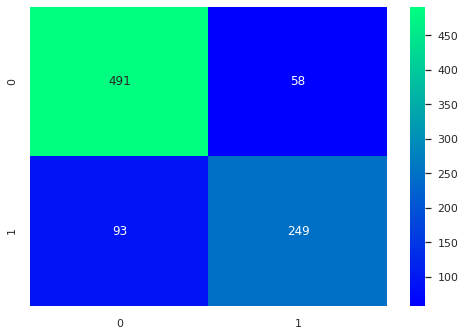

In [ ]:
ada=AdaBoostClassifier(n_estimators=100,random_state=0,learning_rate=0.1)
result=cross_val_predict(ada,X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,result),cmap='winter',annot=True,fmt='2.0f')
plt.show()

## Feature importance

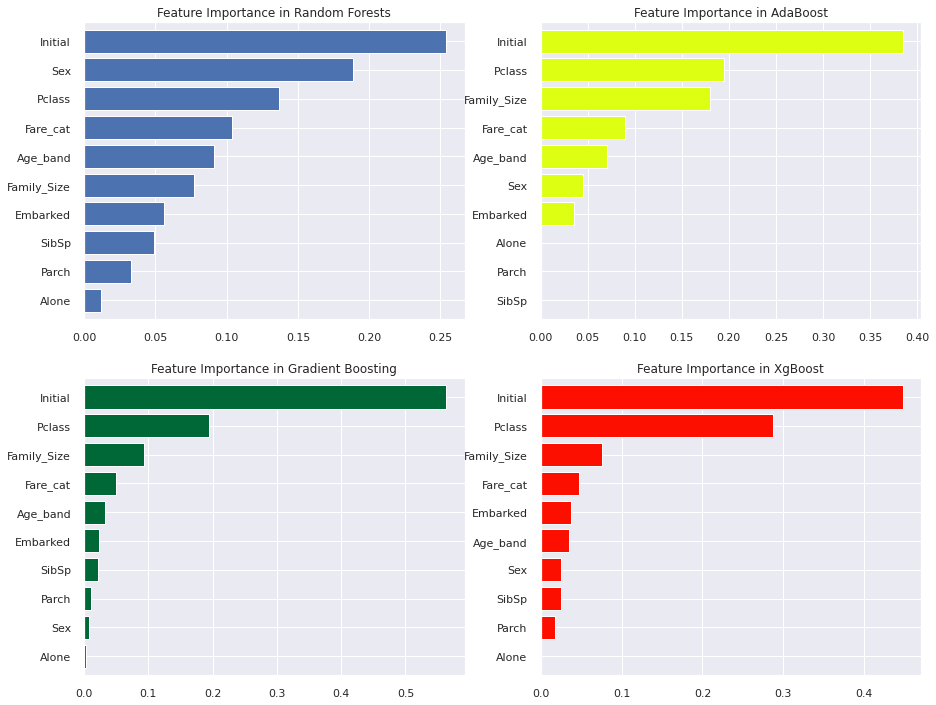

In [ ]:
f,ax=plt.subplots(2,2,figsize=(15,12))
model=RandomForestClassifier(n_estimators=500,random_state=0)
model.fit(X,Y)
pd.Series(model.feature_importances_,X.columns).sort_values(ascending=True).plot.barh(width=0.8,ax=ax[0,0])
ax[0,0].set_title('Feature Importance in Random Forests')
model=AdaBoostClassifier(n_estimators=200,learning_rate=0.05,random_state=0)
model.fit(X,Y)
pd.Series(model.feature_importances_,X.columns).sort_values(ascending=True).plot.barh(width=0.8,ax=ax[0,1],color='#ddff11')
ax[0,1].set_title('Feature Importance in AdaBoost')
model=GradientBoostingClassifier(n_estimators=500,learning_rate=0.1,random_state=0)
model.fit(X,Y)
pd.Series(model.feature_importances_,X.columns).sort_values(ascending=True).plot.barh(width=0.8,ax=ax[1,0],cmap='RdYlGn_r')
ax[1,0].set_title('Feature Importance in Gradient Boosting')
model=xg.XGBClassifier(n_estimators=900,learning_rate=0.1)
model.fit(X,Y)
pd.Series(model.feature_importances_,X.columns).sort_values(ascending=True).plot.barh(width=0.8,ax=ax[1,1],color='#FD0F00')
ax[1,1].set_title('Feature Importance in XgBoost')
plt.show()

1) 일반적인 중요한 기능 중 일부는 Initial, Fare_cat, Pclass, Family_Size입니다.

2) Sex 기능은 중요하지 않은 것 같습니다. 이전에 Pclass와 결합 된 Sex가 매우 좋은 차별화 요소를 제공한다는 것을 이전에 보았 듯이 충격적입니다. 섹스는 RandomForests에서만 중요해 보입니다.

그러나 우리는 많은 분류기에서 최상위에있는 이니셜 기능을 볼 수 있습니다. 우리는 이미 성별과 이니셜 사이의 양의 상관 관계를 보았으므로 둘 다 성별을 나타냅니다.

3) 유사하게 Pclass 및 Fare_cat은 Alone, Parch 및 SibSp와 함께 승객 및 Family_Size의 상태를 나타냅니다.